# Relax Take-home Challenge

Identify which factors predict future user adoption (logging in on three separate days in at least one seven-day period).

* [1. Data Cleaning](#clean)
* [2. EDA](#eda)
* [3. Modeling](#model)
* [4. Conclusions](#conc)

In [1]:
#Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


## Data Cleaning <a name='clean'></a>

Features will be converted into the correct data types.

In [7]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [8]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


#### Missing Values

In [9]:
users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

The two features with missing data is `last_session_creation_time` and `invited_by_user_id`. I'll create a new feature denoting the missing values. 

In [10]:
#Create a function to create new columns marking any missing values
def isna_col(df, col_name, inplace=False):
    """Creates new columns in the dataframe to denote any missing values.
    Missing values will be represented as 1. 
    """
    if (inplace==False):
        new_df = df.copy()
    else:
        new_df = df
    
    #Select the missing values
    isna = new_df[col_name].isna()
        
    #Create new column to denote missing values
    new_colname = col_name + '_isna'
    new_df[new_colname] = 0
    
    #Fill missing values in new column with 1
    new_df.loc[isna, new_colname] = 1
    
    if(inplace==False):
        return new_df

In [11]:
#Create missing features columns
isna_col(users, 'last_session_creation_time', inplace=True)
isna_col(users, 'invited_by_user_id', inplace=True)

users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_isna,invited_by_user_id_isna
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,0


Since roughly half are invited by users, I will also see if I can extract more meaning here. I'll replace user_id's to classify users who've been invited by super users, who I'll define as users inviting 5 or more people, and users who've been invited by regular users.

In [12]:
users.invited_by_user_id.value_counts()

10741.0    13
2527.0     12
1525.0     11
11770.0    11
2308.0     11
           ..
1390.0      1
5445.0      1
8526.0      1
4695.0      1
5450.0      1
Name: invited_by_user_id, Length: 2564, dtype: int64

In [13]:
super_users = users.invited_by_user_id.value_counts()
super_users = super_users[super_users >= 5]
super_users = super_users.index.astype('int').tolist()

In [14]:
#Replace superuser_id with 1
users.loc[users.invited_by_user_id.isin(super_users), 'invited_by_user_id'] = 1

#Replace all other users with 0
users.loc[users['invited_by_user_id']!=1, 'invited_by_user_id'] = 0

#Rename column
users.rename(columns={'invited_by_user_id':'invited_by_superuser'}, inplace=True)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_superuser,last_session_creation_time_isna,invited_by_user_id_isna
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,0.0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,0.0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1.0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1.0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1.0,0,0


Now, I want to explore what's going on with the `last_session_creation_time` before deciding how to fill the missing values.

In [15]:
last_creation_missing_id = users[users.last_session_creation_time.isna()]['object_id']
last_creation_missing_id.unique()

array([    8,     9,    12, ..., 11985, 11993, 11994], dtype=int64)

In [16]:
engagement[engagement.user_id.isin(last_creation_missing_id.unique())]

,time_stamp,user_id,visited


Since it looks like those users haven't even signed in once (perhaps created their accounts but never logged in), they'll be considered as users who weren't adopted. For these, I'll create a new feature column to mark as users who haven't signed in once, and fill the original missing values with the account creation time.

In [17]:
#Fill the missing values with the creation_time
users['last_session_creation_time'].fillna(users['creation_time'], inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   object_id                        12000 non-null  int64         
 1   creation_time                    12000 non-null  datetime64[ns]
 2   name                             12000 non-null  object        
 3   email                            12000 non-null  object        
 4   creation_source                  12000 non-null  object        
 5   last_session_creation_time       12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list         12000 non-null  int64         
 7   enabled_for_marketing_drip       12000 non-null  int64         
 8   org_id                           12000 non-null  int64         
 9   invited_by_superuser             12000 non-null  float64       
 10  last_session_creation_time_isna  12000 non-null  int64    

#### Duplicates
Check for any duplicates in data.

In [18]:
engagement[engagement.duplicated()]

,time_stamp,user_id,visited


In [19]:
users[users.duplicated()]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_superuser,last_session_creation_time_isna,invited_by_user_id_isna


#### One-hot Encoding

In [20]:
cat_features = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'last_session_creation_time_isna', 'invited_by_user_id_isna', 'invited_by_superuser']

#One-hot encode features
dummies = pd.get_dummies(users[cat_features], drop_first=True)
users = users.drop(cat_features, axis=1)
users = users.join(dummies)
users.head()

,object_id,creation_time,name,email,last_session_creation_time,org_id,opted_in_to_mailing_list,enabled_for_marketing_drip,last_session_creation_time_isna,invited_by_user_id_isna,invited_by_superuser,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,11,1,0,0,0,0.0,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,1,0,0,0,0,0.0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,94,0,0,0,0,1.0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,1,0,0,0,0,1.0,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,193,0,0,0,0,1.0,0,0,0,0


#### Feature Engineering
I'll be separating the creation dates more thoroughly.

In [21]:
users['creation_year'] = users['creation_time'].dt.year
users['creation_month'] = users['creation_time'].dt.month
users['creation_day'] = users['creation_time'].dt.day

users['last_session_year'] = users['last_session_creation_time'].dt.year
users['last_session_month'] = users['last_session_creation_time'].dt.month
users['last_session_day'] = users['last_session_creation_time'].dt.day

In [22]:
users.head()

,object_id,creation_time,name,email,last_session_creation_time,org_id,opted_in_to_mailing_list,enabled_for_marketing_drip,last_session_creation_time_isna,invited_by_user_id_isna,...,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,11,1,0,0,0,...,0,0,0,0,2014,4,22,2014,4,22
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,1,0,0,0,0,...,1,0,0,0,2013,11,15,2014,3,31
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,94,0,0,0,0,...,1,0,0,0,2013,3,19,2013,3,19
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,1,0,0,0,0,...,0,0,0,0,2013,5,21,2013,5,22
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,193,0,0,0,0,...,0,0,0,0,2013,1,17,2013,1,22


#### Get logins from last 7 days

First I need to figure out which users meet the criteria of having logins in three separate days within at least one 7-day period. 

In [23]:
engagement[engagement.visited != 1]

,time_stamp,user_id,visited


In [24]:
#Get all users who logged in
login_user = engagement.copy()
login_user = login_user.set_index('time_stamp', drop=True)
login_user = login_user.user_id
login_user

time_stamp
2014-04-22 03:53:30        1
2013-11-15 03:45:04        2
2013-11-29 03:45:04        2
2013-12-09 03:45:04        2
2013-12-25 03:45:04        2
                       ...  
2013-09-06 06:14:15    11996
2013-01-15 18:28:37    11997
2014-04-27 12:45:16    11998
2012-06-02 11:55:59    11999
2014-01-26 08:57:12    12000
Name: user_id, Length: 207917, dtype: int64

In [25]:
#Create function to apply for users and count their 7-day login activity
def max_week_logins(user_id):
    """Count users' 7-day login activity and return the maximum."""
    temp = login_user.loc[login_user==user_id]
    temp = temp.resample('1D').count()
    temp = temp.rolling(7).sum()
    return temp.max()

In [26]:
df_temp = users.copy()
df_temp['max_week_logins'] = df_temp['object_id'].apply(max_week_logins)
df_temp.head()

,object_id,creation_time,name,email,last_session_creation_time,org_id,opted_in_to_mailing_list,enabled_for_marketing_drip,last_session_creation_time_isna,invited_by_user_id_isna,...,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day,max_week_logins
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,11,1,0,0,0,...,0,0,0,2014,4,22,2014,4,22,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,1,0,0,0,0,...,0,0,0,2013,11,15,2014,3,31,3.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,94,0,0,0,0,...,0,0,0,2013,3,19,2013,3,19,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,1,0,0,0,0,...,0,0,0,2013,5,21,2013,5,22,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,193,0,0,0,0,...,0,0,0,2013,1,17,2013,1,22,NaN


In [27]:
#Fill the missing values
df_temp.max_week_logins.fillna(0, inplace=True)

In [28]:
df_temp.max_week_logins.value_counts()

0.0    9475
7.0     621
2.0     524
1.0     404
3.0     300
6.0     237
5.0     223
4.0     216
Name: max_week_logins, dtype: int64

Quick logic check:

In [29]:
df_temp[df_temp.max_week_logins==2]

,object_id,creation_time,name,email,last_session_creation_time,org_id,opted_in_to_mailing_list,enabled_for_marketing_drip,last_session_creation_time_isna,invited_by_user_id_isna,...,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day,max_week_logins
59,60,2014-03-21 22:56:03,McEacharn Archie,ArchieMcEacharn@gmail.com,2014-05-15 22:56:03,88,0,0,0,0,...,0,0,0,2014,3,21,2014,5,15,2.0
76,77,2012-12-20 16:31:21,Melo Isabella,IsabellaSilvaMelo@jourrapide.com,2013-01-17 16:31:21,68,1,1,0,1,...,0,1,0,2012,12,20,2013,1,17,2.0
125,126,2013-08-09 12:00:02,Rodrigues Tânia,TaniaAlvesRodrigues@gmail.com,2013-09-24 12:00:02,112,1,1,0,0,...,0,0,0,2013,8,9,2013,9,24,2.0
135,136,2014-04-02 18:50:13,Gregersen Simone,SimoneDGregersen@gmail.com,2014-05-21 18:50:13,92,1,0,0,1,...,0,0,1,2014,4,2,2014,5,21,2.0
141,142,2014-03-03 00:48:56,Eriksen Victoria,VictoriaOEriksen@yahoo.com,2014-05-25 00:48:56,95,0,0,0,1,...,1,0,0,2014,3,3,2014,5,25,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,11935,2012-12-16 06:32:23,Wong Zachary,mehzcmdc@enefm.com,2013-01-30 06:32:23,22,1,1,0,0,...,0,0,0,2012,12,16,2013,1,30,2.0
11948,11949,2014-01-20 21:51:30,Villadsen Noah,NoahMVilladsen@hotmail.com,2014-05-28 21:51:30,156,0,0,0,0,...,0,0,0,2014,1,20,2014,5,28,2.0
11979,11980,2014-02-02 15:23:18,Gloeckner Franziska,ljnnbqdr@cgbld.com,2014-04-18 15:23:18,406,0,0,0,0,...,0,0,0,2014,2,2,2014,4,18,2.0
11980,11981,2013-03-05 01:53:48,Fry Tyler,TylerFry@gmail.com,2013-04-02 01:53:48,110,0,0,0,0,...,0,0,0,2013,3,5,2013,4,2,2.0


In [30]:
engagement[engagement.user_id == 60]

,time_stamp,user_id,visited
740,2014-03-21 22:56:03,60,1
741,2014-03-29 22:56:03,60,1
742,2014-04-02 22:56:03,60,1
743,2014-04-05 22:56:03,60,1
744,2014-04-22 22:56:03,60,1
745,2014-04-28 22:56:03,60,1
746,2014-05-13 22:56:03,60,1
747,2014-05-15 22:56:03,60,1


The logic seems correct, given that a week starting from 3/29 would be until 4/04. The maximum number of weekly logins for this user is indeed 2.

In [31]:
#Create target variable
users['adopted'] = df_temp.max_week_logins >= 3
users.adopted.replace(to_replace={True:1, False:0}, inplace=True)
users.head()

,object_id,creation_time,name,email,last_session_creation_time,org_id,opted_in_to_mailing_list,enabled_for_marketing_drip,last_session_creation_time_isna,invited_by_user_id_isna,...,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,11,1,0,0,0,...,0,0,0,2014,4,22,2014,4,22,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,1,0,0,0,0,...,0,0,0,2013,11,15,2014,3,31,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,94,0,0,0,0,...,0,0,0,2013,3,19,2013,3,19,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,1,0,0,0,0,...,0,0,0,2013,5,21,2013,5,22,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,193,0,0,0,0,...,0,0,0,2013,1,17,2013,1,22,0


In [32]:
users.adopted.value_counts()

0    10403
1     1597
Name: adopted, dtype: int64

There's a big class imbalance here, with only 1597/12,000 users adopted.

## EDA <a name='eda'></a>
For some quick EDA, I want to see which features are correlated.

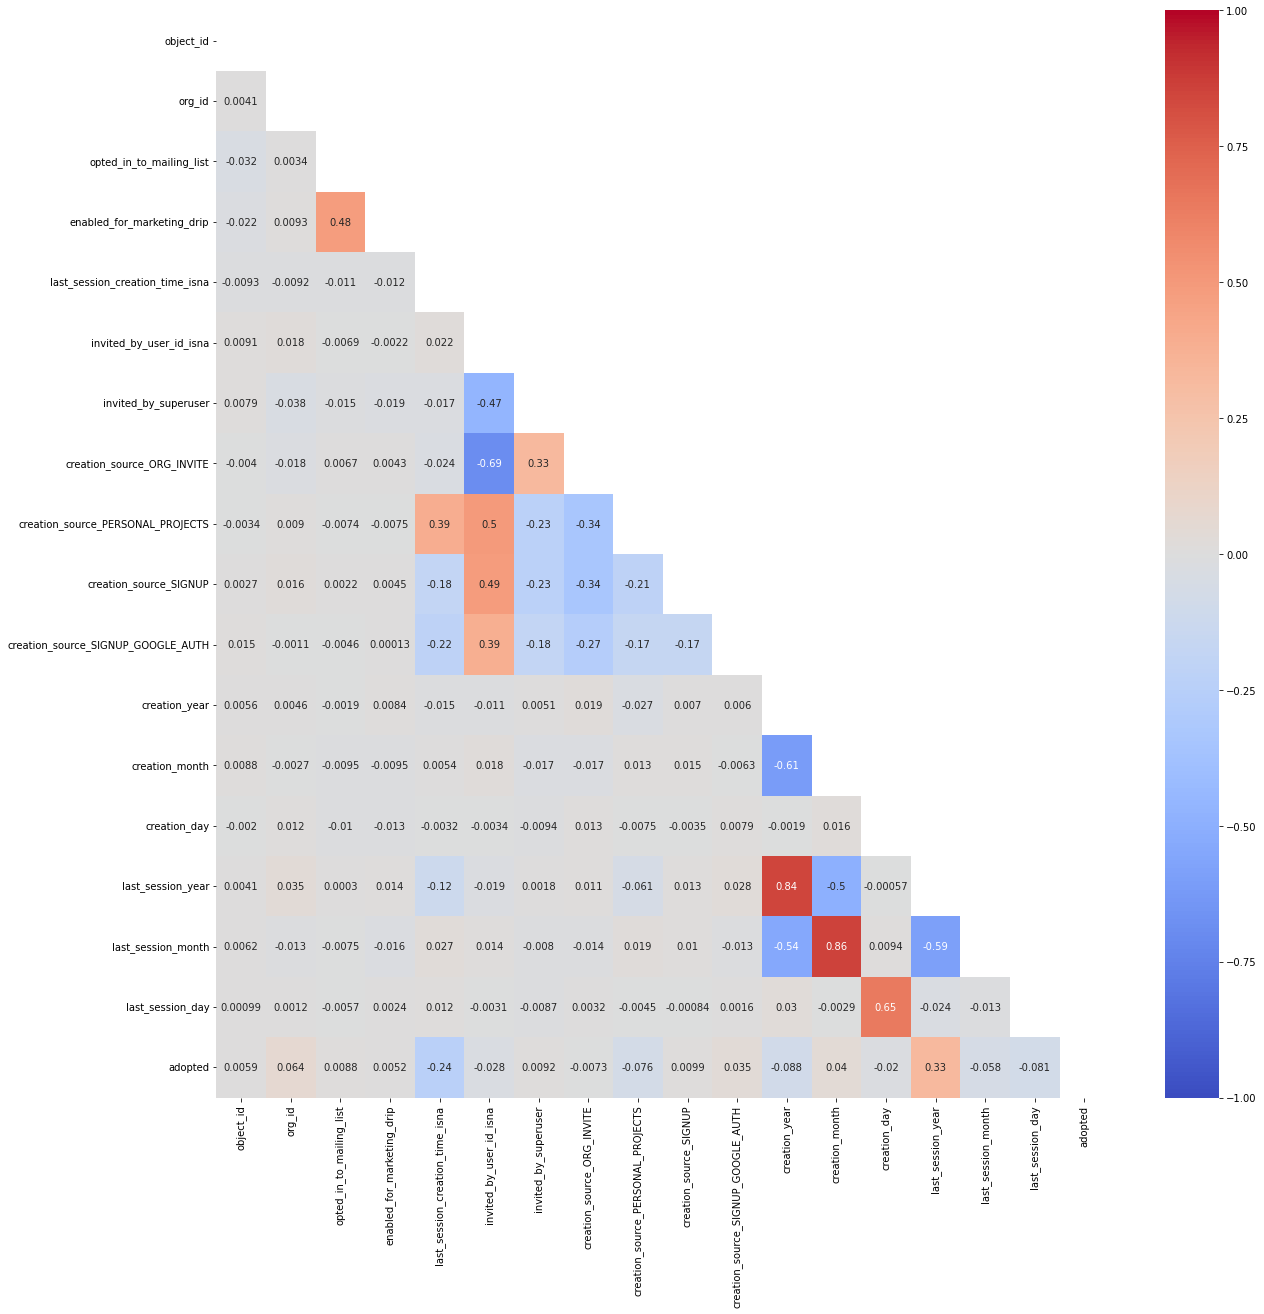

In [33]:
#Check for any correlations
corr = users.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [34]:
users.corr()['adopted']

object_id                             0.005925
org_id                                0.064366
opted_in_to_mailing_list              0.008815
enabled_for_marketing_drip            0.005173
last_session_creation_time_isna      -0.235111
invited_by_user_id_isna              -0.028039
invited_by_superuser                  0.009153
creation_source_ORG_INVITE           -0.007250
creation_source_PERSONAL_PROJECTS    -0.075995
creation_source_SIGNUP                0.009874
creation_source_SIGNUP_GOOGLE_AUTH    0.035074
creation_year                        -0.088230
creation_month                        0.039799
creation_day                         -0.019525
last_session_year                     0.327126
last_session_month                   -0.058333
last_session_day                     -0.081484
adopted                               1.000000
Name: adopted, dtype: float64

There aren't any high correlations, but one of the features most correlated (negatively) is whether the user signed in or not, which makes sense since a user has to sign in at least once to be considered as adopted.

## Modeling <a name='model'></a>
Since there isn't much time, I'll only create a benchmark and one Random Forest model to look at important features.

I'll also be dropping the name, email, and creation time/last session creation time columns. Names and emails will have little meaning since it's so unique, and the (last session) creation time has been stored into its separate categories.

In [35]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'org_id', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'last_session_creation_time_isna',
       'invited_by_user_id_isna', 'invited_by_superuser',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH',
       'creation_year', 'creation_month', 'creation_day', 'last_session_year',
       'last_session_month', 'last_session_day', 'adopted'],
      dtype='object')

In [36]:
X = users.drop(['adopted', 'creation_time', 'name', 'email', 'last_session_creation_time'], axis=1)
y = users[['adopted']]

#Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
num_features = ['creation_year', 'creation_month', 'creation_day', 'org_id', 'last_session_year', 'last_session_month', 'last_session_day']
cat_features = ['opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'last_session_creation_time_isna',
       'invited_by_user_id_isna', 'invited_by_superuser',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']

#Build a pipeline to scale numerical variables
pipeline = ColumnTransformer([('num', StandardScaler(), num_features),
                            ('cat', 'passthrough', cat_features)])

X_train_ = pipeline.fit_transform(X_train)
X_test_ = pipeline.transform(X_test)

In [38]:
#Create classifier benchmark
dummy = DummyClassifier(strategy='constant', constant=0)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

metrics = pd.DataFrame(columns=['accuracy', 'f1', 'roc_auc_score'])
metrics.loc['Benchmark', 'accuracy'] = accuracy_score(y_test, y_pred)
metrics.loc['Benchmark','f1'] = f1_score(y_test, y_pred)
metrics.loc['Benchmark','roc_auc_score'] = roc_auc_score(y_test, y_pred)

metrics

,accuracy,f1,roc_auc_score
Benchmark,0.867083,0.0,0.5


In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9600 entries, 9028 to 6051
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   object_id                           9600 non-null   int64  
 1   org_id                              9600 non-null   int64  
 2   opted_in_to_mailing_list            9600 non-null   int64  
 3   enabled_for_marketing_drip          9600 non-null   int64  
 4   last_session_creation_time_isna     9600 non-null   int64  
 5   invited_by_user_id_isna             9600 non-null   int64  
 6   invited_by_superuser                9600 non-null   float64
 7   creation_source_ORG_INVITE          9600 non-null   uint8  
 8   creation_source_PERSONAL_PROJECTS   9600 non-null   uint8  
 9   creation_source_SIGNUP              9600 non-null   uint8  
 10  creation_source_SIGNUP_GOOGLE_AUTH  9600 non-null   uint8  
 11  creation_year                       9600

In [40]:
#RandomForest modeling
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

metrics.loc['Random Forest', 'accuracy'] = accuracy_score(y_test, y_pred)
metrics.loc['Random Forest','f1'] = f1_score(y_test, y_pred)
metrics.loc['Random Forest','roc_auc_score'] = roc_auc_score(y_test, y_pred)

metrics

,accuracy,f1,roc_auc_score
Benchmark,0.867083,0.0,0.5
Random Forest,0.965,0.858108,0.893554


In [41]:
rf.feature_importances_

array([0.04563438, 0.04208929, 0.00562745, 0.00483439, 0.02554779,
       0.00414119, 0.00495746, 0.00509407, 0.00420573, 0.0037838 ,
       0.00314822, 0.12842121, 0.16190502, 0.10027527, 0.18902728,
       0.1752456 , 0.09606184])

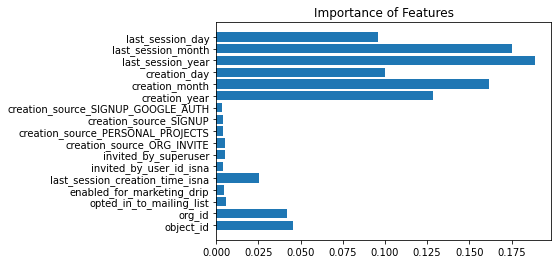

In [42]:
#Plot the feature importances
feature_name = X_train.columns
plt.barh(feature_name, rf.feature_importances_)
plt.title('Importance of Features')
plt.show()

## Conclusions <a name='conc'></a>
A quick random forest is a good estimator for this, but I expect this to be because of the last session dates. Since this is directly correlated with how adoption is calculated. Perhaps the creation dates are actually important.

However, aside from these dates, the model doesn't find any of the features to be too important. This is in line with the correlation map.